In [285]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup as bs
import urllib
import json
import cv2
import image_similarity_measures
from sys import argv
from image_similarity_measures.quality_metrics import rmse, ssim, sre
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import math
import unicodedata
from urllib.request import Request, urlopen
import random
from sklearn import preprocessing

import sys
import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

In [286]:
GranCat = pd.read_csv("/Users/emma/Desktop/Changing Room/Work/Database/LowLevelCatagoryRegex.csv", 
                      header=None,
                      skiprows=[0])

def process_cat(df):
    # get all the values in category regex
    subCats = GranCat.iloc[:, 1:]
    Cats = []
    for index, row in subCats.iterrows():
        for i in GranCat.columns[1:]:
            if pd.isnull(row[i]): continue
            else: Cats.append(row[i])
                
    # assign potential category for each clothing row based on title, else other
    clothesCat = []
    for index, row in df.iterrows():
        rowCat = float("NaN")
        for cat in Cats:
            if re.search(cat, row['display_name'].lower()):
                rowCat = cat
                break
        if pd.isnull(rowCat): clothesCat.append('other')
        else: clothesCat.append(rowCat)
    return clothesCat

# set parent category to each product
def get_cat(x):
    if x == 'other': return x
    else: return [GranCat[0][i] for i in GranCat.index if x in GranCat.iloc[i].to_list()][0]

# get low_level column given a df
def get_lowlevel(df):
    df['low_level'] = process_cat(df)
    df['low_level'] = df['low_level'].apply(lambda x: get_cat(x))
    return df

In [287]:
def url_to_image(url):
    
    user_agent_list = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.112 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_2) AppleWebKit/535.24 (KHTML, like Gecko) Chrome/19.0.1055.1 Safari/535.24',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.112 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1664.3 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.112 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1847.131 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.89 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36',
                       'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_3_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36']
    user_agent = user_agent_list[random.randint(0,12)]
    HEADERS = {'User-Agent': user_agent}
    
    # download the image, convert it to a NumPy array, and then read it into OpenCV format
    req = Request(url, headers=HEADERS)
    resp = urlopen(req)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

In [288]:
def get_gender(x):
    try:
        x = x.lower()
        if 'women' in x: return 'Women'
        elif 'men' in x: return 'Men'
        elif 'kid' in x: return 'Kids'
        else: return 'Unisex'
    except: return 'Unknown'

# Clean

In [306]:
df = pd.read_csv('shopify_updated.csv')
df['overallscore'] = 4.5
df = get_lowlevel(df)
df['gender'] = df['category']+df['display_name']
df['gender'] = df['gender'].apply(lambda x: get_gender(x))

# Image Recommendation

In [290]:
def image_recommendation(url, data=df, N=5):
    
    data['image_link_color'] = data['image_link_color'].apply(lambda x: json.loads(x.replace("\'", "\"")))
    data['image_link'] = [list(i.values()) for i in data.image_link_color.tolist()]
    
    # get info based on input url
    cat = data[data['product_url'] == url]['low_level'].values[0]
    image_link_list = data[data['product_url'] == url]['image_link'].values[0]
    target_url = image_link_list[0]
    score = data[data['product_url'] == url]['overallscore'].values[0]
    gender = data[data['product_url'] == url]['gender'].values[0]
    subdf = data[(data['low_level'] == cat) & (data['overallscore'] >= score) & 
                 ((data['gender'] == gender) | (data['gender'] == 'Unisex'))]

    img = argv[1]
    test_img = url_to_image(target_url)

    scale_percent = 100
    width = int(test_img.shape[1] * scale_percent / 100)
    height = int(test_img.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    def return_similarity(image_link_list):
        score_list = []
        for image_link in image_link_list:
            try:
                data_img = url_to_image(image_link)
                resized_img = cv2.resize(data_img, dim, interpolation = cv2.INTER_AREA)

                # three measures
                ssim_score = ssim(test_img, resized_img)
                sre_score = sre(test_img, resized_img)
                rmse_score = rmse(test_img, resized_img)
                
                # total measurements
                total_score = ssim_score + sre_score - rmse_score
                score_list.append(total_score)
            except:
                score_list.append(0)
        return score_list
    
    subdf['image_similarity'] = subdf['image_link'].apply(lambda x: return_similarity(x))
    subdf['image_sim'] = subdf['image_similarity'].apply(lambda x: max(x))
    
    res = subdf.sort_values(['image_sim'], ascending=False)[1:N+1]
    
    for idx, row in res.iterrows():
        print('Name:', row['display_name'])
        fig = plt.figure()
        plt.imshow(url_to_image(row['image_link'][0]), cmap = plt.cm.gray)
        plt.axis("off")
        plt.show()
        print('URL:', row['product_url'])
        print()
    
    return res

Name: LONGBOARDER TEE


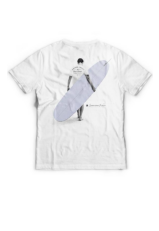

URL: https://www.panamunaproject.com.au/products/longboarder-tee

Name: CANNED TEE


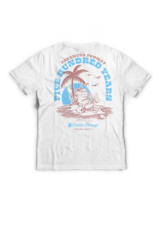

URL: https://www.panamunaproject.com.au/products/canned-tee

Name: PARASUIT PKT TEE WHITE


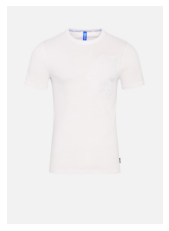

URL: https://www.raeburndesign.co.uk/products/parasuit-pkt-tee-white

Name: Organic cotton cropped shoulder t-shirt with C-FIBER™—sand


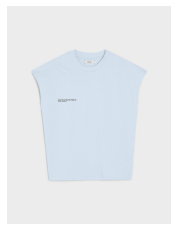

URL: https://thepangaia.com/products/organic-cotton-cropped-shoulder-t-shirt-with-c-fiber-sand

Name: Organic cotton t-shirt with C-FIBER™—sand


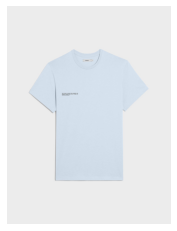

URL: https://thepangaia.com/products/organic-cotton-t-shirt-with-c-fiber-sand



,Unnamed: 0,brand_url,category,display_name,variant,price,in_stock,product_url,image_link_color,body_html,...,condition,product_material,color,size,low_level,overallscore,gender,image_link,image_similarity,image_sim
5,5,https://www.panamunaproject.com.au,UNISEX T-Shirt,LONGBOARDER TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/lo...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,"<span style=""font-weight: 400;"">The Long Board...",...,New,NaN,Unknown,S,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,[65.3829786188187],65.382979
2,2,https://www.panamunaproject.com.au,UNISEX T-Shirt,CANNED TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/ca...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,"<span style=""font-weight: 400;"">The Canned Tee...",...,New,NaN,Unknown,S,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,[64.67388079889717],64.673881
106,106,https://www.raeburndesign.co.uk,"40000 - JERSEY, SWEATS, FLEECE, POLOS & TEES",PARASUIT PKT TEE WHITE,"['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL']",79.0,"[False, True, True, False, True, False, False]",https://www.raeburndesign.co.uk/products/paras...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,<p>The RÆBURN Parasuit Tee features a signatur...,...,New,NaN,Unknown,XS,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/0382/8714/7...,[64.25736425821842],64.257364
2308,6967,https://thepangaia.com,Clothes,Organic cotton cropped shoulder t-shirt with C...,"['Sand XXS', 'Sand XS', 'Sand S', 'Sand M', 'S...",65.0,"[True, True, True, True, True, True, True]",https://thepangaia.com/products/organic-cotton...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,"<meta charset=""utf-8"">\n<p>This Sand Cropped S...",...,New,NaN,Unknown,Sand XXS,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/0035/1309/0...,[63.98147267361509],63.981473
2283,6942,https://thepangaia.com,Clothes,Organic cotton t-shirt with C-FIBER™—sand,"['Sand XXS', 'Sand XS', 'Sand S', 'Sand M', 'S...",75.0,"[True, True, True, True, True, True, False]",https://thepangaia.com/products/organic-cotton...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,"<meta charset=""utf-8"">\n<p>This Sand T-Shirt i...",...,New,NaN,Unknown,Sand XXS,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/0035/1309/0...,[63.93287901086793],63.932879


In [291]:
url = 'https://www.panamunaproject.com.au/products/empower-tee'
image_recommendation(url, data=df)

# Text Recommendation

In [292]:
df = pd.read_csv('shopify_updated.csv')
df['overallscore'] = 4.5
df = get_lowlevel(df)
df['gender'] = df['category']+df['display_name']
df['gender'] = df['gender'].apply(lambda x: get_gender(x))

In [293]:
def text_recommendation(url, data=df, N=5):
    
    data['image_link_color'] = data['image_link_color'].apply(lambda x: json.loads(x.replace("\'", "\"")))
    data['image_link'] = [list(i.values()) for i in data.image_link_color.tolist()]
    
    # get the cosine similarity matrix
    def return_similarity(data, attribute='description'):
        data[attribute] = data[attribute].fillna('')
        tfidf_matrix = TfidfVectorizer(stop_words='english').fit_transform(data[attribute]) 
        cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
        return cosine_sim
    
    # get the sub dataframe with the same category and higher score
    cat = data[data['product_url'] == url]['low_level'].values[0]
    score = data[data['product_url'] == url]['overallscore'].values[0]
    subdf = data[(data['low_level'] == cat) & (data['overallscore']>=score)]

    subdf = subdf.reset_index()
    idx = subdf.index[subdf['product_url'] == url].values[0]

    # DESCRIPTION SIMILARITY
    desc_sim = return_similarity(data = subdf, attribute='description')
    d_sim_scores = list(enumerate(desc_sim[idx]))
    d_sim_scores = sorted(d_sim_scores, key=lambda x: x[1], reverse=True)
    sim_df = pd.DataFrame(d_sim_scores, columns=['index','sim']).set_index('index')
    subdf['desc_similarity'] = subdf.index.to_series().map(sim_df['sim'])

    # TITLE SIMILARITY
    title_sim = return_similarity(data = subdf, attribute='display_name')
    t_sim_scores = list(enumerate(title_sim[idx]))
    t_sim_scores = sorted(t_sim_scores, key=lambda x: x[1], reverse=True)
    t_sim_df = pd.DataFrame(t_sim_scores, columns=['index','sim']).set_index('index')
    subdf['title_similarity'] = subdf.index.to_series().map(t_sim_df['sim'])
 
    res = subdf.sort_values(['desc_similarity', 'title_similarity'], ascending=False)[1:N+1]
    
    for idx, row in res.iterrows():
        print('Name:', row['display_name'])
        fig = plt.figure()
        plt.imshow(url_to_image(row['image_link'][0]), cmap = plt.cm.gray)
        plt.axis("off")
        plt.show()
        print('Description:', row['description'])
        print('URL:', row['product_url'])
        print()
    
    return res

Name: CLASSIC TEE


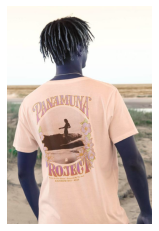

Description: The Classic Tee looks good but it feels even better on your skin. Made from 100% organic, ethically sourced cotton, the t-shirt goes gentle on the skin. The elegant print on the Classic Tee is designed with water-based ink. The t-shirts are printed on-demand, leading to zero waste of resources. Speaking of preserving resources, we at Panamuna Project believe in following a sustainable lifestyle to help our planet breathe easy. Our products, including the Long Boarder Tee, meet the Global Organic Textile Standard (GOTS) while supporting the efforts of Carbon Trust, Fair Wear Foundation, and Soil Association. So the next time you're out with your friends, rocking the Classic Tee under the sun, know that you're part of a community committed to a green lifestyle.  So what are you waiting for? Flaunt the pretty Classic Tee from Panamuna Project to make the world a better place, one shirt at a time.  CONSTRUCTION
URL: https://www.panamunaproject.com.au/products/classic-tee

Name

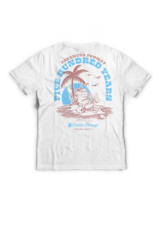

Description: The Canned Tee looks good but it feels even better on your skin. Made from 100% organic, ethically sourced cotton, the t-shirt goes gentle on the skin. The elegant print on the Canned Tee is designed with water-based ink. The t-shirts are printed on-demand, leading to zero waste of resources. Speaking of preserving resources, we at Panamuna Project believe in following a sustainable lifestyle to help our planet breathe easy. Our products, including the Canned Tee, meet the Global Organic Textile Standard (GOTS) while supporting the efforts of Carbon Trust, Fair Wear Foundation, and Soil Association. So the next time you're out with your friends, rocking the Classic Tee under the sun, know that you're part of a community committed to a green lifestyle.  So what are you waiting for? Flaunt the pretty Canned Tee from Panamuna Project to make the world a better place, one shirt at a time.  CONSTRUCTION
URL: https://www.panamunaproject.com.au/products/canned-tee

Name: POWERED 

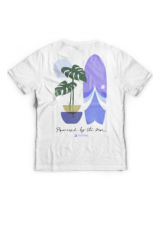

Description: The Powered Tee looks good but it feels even better on your skin. Made from 100% organic, ethically sourced cotton, the t-shirt goes gentle on the skin. The elegant print on the Powered Tee is designed with water-based ink. The t-shirts are printed on-demand, leading to zero waste of resources. Speaking of preserving resources, we at Panamuna Project believe in following a sustainable lifestyle to help our planet breathe easy. Our products, including the Powered Tee, meet the Global Organic Textile Standard (GOTS) while supporting the efforts of Carbon Trust, Fair Wear Foundation, and Soil Association. So the next time you're out with your friends, rocking the Alaska Tee under the sun, know that you're part of a community committed to a green lifestyle.  So what are you waiting for? Flaunt the pretty Powered Tee from Panamuna Project to make the world a better place, one shirt at a time.  CONSTRUCTION
URL: https://www.panamunaproject.com.au/products/powered-tee

Name: LONG

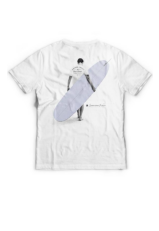

Description: The Long Boarder Tee looks good but it feels even better on your skin. Made from 100% organic, ethically sourced cotton, the t-shirt goes gentle on the skin. The elegant print on the Long Boarder Tee is designed with water-based ink. The t-shirts are printed on-demand, leading to zero waste of resources. Speaking of preserving resources, we at Panamuna Project believe in following a sustainable lifestyle to help our planet breathe easy. Our products, including the Long Boarder Tee, meet the Global Organic Textile Standard (GOTS) while supporting the efforts of Carbon Trust, Fair Wear Foundation, and Soil Association. So the next time you're out with your friends, rocking the Alaska Tee under the sun, know that you're part of a community committed to a green lifestyle.  So what are you waiting for? Flaunt the pretty Long Boarder Tee from Panamuna Project to make the world a better place, one shirt at a time.  CONSTRUCTION
URL: https://www.panamunaproject.com.au/products/lon

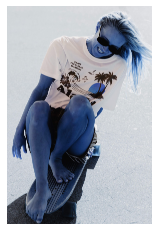

Description: Global warming may have been making life miserable in most of the world but for Alaska, a bit of summer is always fun. The Alaska Tee is a dynamic yet chic style statement that is full of casual energy.  The Alaska Tee looks good but it feels even better on your skin. Made from 100% organic, ethically sourced cotton, the t-shirt goes gentle on the skin. The elegant print on the Alaska Tee is designed with water-based ink. The t-shirts are printed on-demand, leading to zero waste of resources. Speaking of preserving resources, we at Panamuna Project believe in following a sustainable lifestyle to help our planet breathe easy. Our products, including the Alaska Tee, meet the Global Organic Textile Standard (GOTS) while supporting the efforts of Carbon Trust, Fair Wear Foundation, and Soil Association. So the next time you're out with your friends, rocking the Alaska Tee under the sun, know that you're part of a community committed to a green lifestyle.  So what are you waiti

,index,Unnamed: 0,brand_url,category,display_name,variant,price,in_stock,product_url,image_link_color,...,condition,product_material,color,size,low_level,overallscore,gender,image_link,desc_similarity,title_similarity
3,3,3,https://www.panamunaproject.com.au,UNISEX T-Shirt,CLASSIC TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/cl...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,New,NaN,Unknown,S,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,0.776998,0.113067
2,2,2,https://www.panamunaproject.com.au,UNISEX T-Shirt,CANNED TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/ca...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,New,NaN,Unknown,S,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,0.687687,0.113067
5,6,6,https://www.panamunaproject.com.au,UNISEX T-Shirt,POWERED TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/po...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,New,NaN,Unknown,S,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,0.676184,0.113067
4,5,5,https://www.panamunaproject.com.au,UNISEX T-Shirt,LONGBOARDER TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/lo...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,New,NaN,Unknown,S,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,0.672654,0.113067
18,23,23,https://www.panamunaproject.com.au,UNISEX T-Shirt,ALASKA TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/al...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,New,NaN,Unknown,S,T-Shirts,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,0.546034,0.113067


In [294]:
url = 'https://www.panamunaproject.com.au/products/empower-tee'
text_recommendation(url, data=df)

# Combine Text-based & Image-based

In [277]:
df = pd.read_csv('shopify_updated.csv')
df['overallscore'] = 4.5
df = get_lowlevel(df)
df['gender'] = df['category']+df['display_name']
df['gender'] = df['gender'].apply(lambda x: get_gender(x))

In [278]:
def recommendation(url, data=df, N=5):
    
    data['image_link_color'] = data['image_link_color'].apply(lambda x: json.loads(x.replace("\'", "\"")))
    data['image_link'] = [list(i.values()) for i in data.image_link_color.tolist()]
    
    # get info based on input url
    cat = data[data['product_url'] == url]['low_level'].values[0]
    image_link_list = data[data['product_url'] == url]['image_link'].values[0]
    target_url = image_link_list[0]
    score = data[data['product_url'] == url]['overallscore'].values[0]
    gender = data[data['product_url'] == url]['gender'].values[0]
    subdf = data[(data['low_level'] == cat) & (data['overallscore'] >= score) & 
                 ((data['gender'] == gender) | (data['gender'] == 'Unisex'))]
    
    
    # IMAGE-BASED RECOMMENDATION
    img = argv[1]
    test_img = url_to_image(target_url)

    scale_percent = 100
    width = int(test_img.shape[1] * scale_percent / 100)
    height = int(test_img.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    def return_similarity(image_link_list):
        score_list = []
        for image_link in image_link_list:
            try:
                data_img = url_to_image(image_link)
                resized_img = cv2.resize(data_img, dim, interpolation = cv2.INTER_AREA)

                # three measures
                ssim_score = ssim(test_img, resized_img)
                sre_score = sre(test_img, resized_img)
                rmse_score = rmse(test_img, resized_img)
                
                # total measurements
                total_score = ssim_score + sre_score - rmse_score
                score_list.append(total_score)
            except:
                score_list.append(0)
        return score_list
    
    subdf['image_similarity'] = subdf['image_link'].apply(lambda x: return_similarity(x))
    subdf['image_sim'] = subdf['image_similarity'].apply(lambda x: max(x))
    m = subdf.loc[subdf['image_sim'] != np.inf, 'image_sim'].max()
    subdf['image_sim'] = subdf['image_sim'].replace(np.inf, m)
    
    
    # TEXT-BASED RECOMMENDATION
    def return_similarity(data, attribute='description'):
        data[attribute] = data[attribute].fillna('')
        tfidf_matrix = TfidfVectorizer(stop_words='english').fit_transform(data[attribute]) 
        cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
        return cosine_sim
    
    subdf = subdf.reset_index()
    idx = subdf.index[subdf['product_url'] == url].values[0]
    # description
    desc_sim = return_similarity(data = subdf, attribute='description')
    d_sim_scores = list(enumerate(desc_sim[idx]))
    d_sim_scores = sorted(d_sim_scores, key=lambda x: x[1], reverse=True)
    sim_df = pd.DataFrame(d_sim_scores, columns=['index','sim']).set_index('index')
    subdf['desc_similarity'] = subdf.index.to_series().map(sim_df['sim'])

    # title
    title_sim = return_similarity(data = subdf, attribute='display_name')
    t_sim_scores = list(enumerate(title_sim[idx]))
    t_sim_scores = sorted(t_sim_scores, key=lambda x: x[1], reverse=True)
    t_sim_df = pd.DataFrame(t_sim_scores, columns=['index','sim']).set_index('index')
    subdf['title_similarity'] = subdf.index.to_series().map(t_sim_df['sim'])
    
    # combine title and description similarity
    subdf['text_sim'] = subdf['desc_similarity'] + subdf['title_similarity']
    
    # standardize scores 
    subdf['image_sim_norm'] = preprocessing.StandardScaler().fit_transform(np.array(subdf['image_sim']).reshape(-1,1))
    subdf['text_sim_norm'] = preprocessing.StandardScaler().fit_transform(np.array(subdf['text_sim']).reshape(-1,1))
    
    # sort by image similarity and text similarity
    res = subdf.sort_values(['image_sim_norm', 'text_sim_norm'], ascending=False)[1:N+1]
    
    for idx, row in res.iterrows():
        print('Name:', row['display_name'])
        fig = plt.figure()
        plt.imshow(url_to_image(row['image_link'][0]), cmap = plt.cm.gray)
        plt.axis("off")
        plt.show()
        print('Description:', row['description'])
        print('URL:', row['product_url'])
        print()
    
    return res

Name: LONGBOARDER TEE


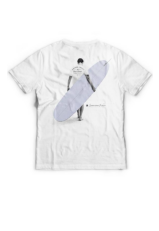

Description: The Long Boarder Tee looks good but it feels even better on your skin. Made from 100% organic, ethically sourced cotton, the t-shirt goes gentle on the skin. The elegant print on the Long Boarder Tee is designed with water-based ink. The t-shirts are printed on-demand, leading to zero waste of resources. Speaking of preserving resources, we at Panamuna Project believe in following a sustainable lifestyle to help our planet breathe easy. Our products, including the Long Boarder Tee, meet the Global Organic Textile Standard (GOTS) while supporting the efforts of Carbon Trust, Fair Wear Foundation, and Soil Association. So the next time you're out with your friends, rocking the Alaska Tee under the sun, know that you're part of a community committed to a green lifestyle.  So what are you waiting for? Flaunt the pretty Long Boarder Tee from Panamuna Project to make the world a better place, one shirt at a time.  CONSTRUCTION
URL: https://www.panamunaproject.com.au/products/lon

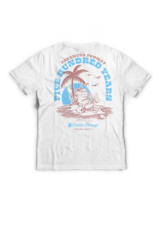

Description: The Canned Tee looks good but it feels even better on your skin. Made from 100% organic, ethically sourced cotton, the t-shirt goes gentle on the skin. The elegant print on the Canned Tee is designed with water-based ink. The t-shirts are printed on-demand, leading to zero waste of resources. Speaking of preserving resources, we at Panamuna Project believe in following a sustainable lifestyle to help our planet breathe easy. Our products, including the Canned Tee, meet the Global Organic Textile Standard (GOTS) while supporting the efforts of Carbon Trust, Fair Wear Foundation, and Soil Association. So the next time you're out with your friends, rocking the Classic Tee under the sun, know that you're part of a community committed to a green lifestyle.  So what are you waiting for? Flaunt the pretty Canned Tee from Panamuna Project to make the world a better place, one shirt at a time.  CONSTRUCTION
URL: https://www.panamunaproject.com.au/products/canned-tee

Name: PARASUIT

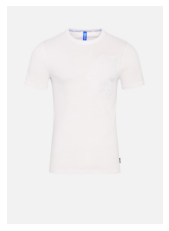

Description: The RÆBURN Parasuit Tee features a signature chest pocket, RÆMADE using original parachute canopies which have been over-dyed in the UK to achieve a textured and lightweight crinkle here, then applied here at the RÆBURN Lab in East London. The base has been manufactured in Portugal and produced in a 170gsm Global Organic Textile Standard Approved 100% organic cotton interlock which meets the OCS 100 - Organic Content Standard, verifying the presence and amount of organic content in the final raw material. The fabric is piece dyed in in GOTS certified dye house to meet Standard 100 by Oeko-Tex® confirming they have been tested for harmful substances and given carbon brushed finish to give a luxury hand feel. Organic interlock w. carbon brush finish Organic cotton rib to collar Signature RÆBURN set in sleeve to front shoulder, extending to raglan seam at back RÆBURN branded tab to side seam LHSAW Straight hem finish Cover stitch seam construction throughout RÆMADE Parachute 

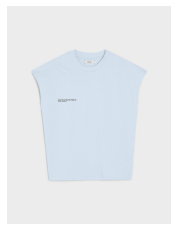

Description: This Sand Cropped Shoulder T-shirt is made with saltwater Seaweed Fiber, Organic Cotton and treated with our trademark technology: PPRMINT™ oil. PPRMINT™ has natural antibacterial and antimicrobial properties to keep your T-shirt fresh for longer, meaning it can be washed less often—saving water, energy and time.   ### Maya is 172cm / 5’8, she is wearing size S
URL: https://thepangaia.com/products/organic-cotton-cropped-shoulder-t-shirt-with-c-fiber-sand

Name: Organic cotton t-shirt with C-FIBER™—sand


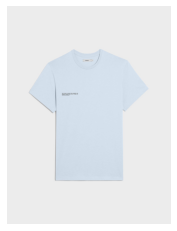

Description: This Sand T-Shirt is made with saltwater Seaweed Fiber, Organic Cotton and treated with our trademark technology: PPRMINT™ oil. PPRMINT™ has natural antibacterial and antimicrobial properties to keep your T-shirt fresh for longer, meaning it can be washed less often—saving water, energy and time. ### Ella is 180cm / 5’11, she is wearing a size L.
URL: https://thepangaia.com/products/organic-cotton-t-shirt-with-c-fiber-sand



,index,Unnamed: 0,brand_url,category,display_name,variant,price,in_stock,product_url,image_link_color,...,overallscore,gender,image_link,image_similarity,image_sim,desc_similarity,title_similarity,text_sim,image_sim_norm,text_sim_norm
3,5,5,https://www.panamunaproject.com.au,UNISEX T-Shirt,LONGBOARDER TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/lo...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,[65.3829786188187],65.382979,0.668547,0.104245,0.772792,0.699695,4.613928
1,2,2,https://www.panamunaproject.com.au,UNISEX T-Shirt,CANNED TEE,"['S', 'M', 'L', 'XL', 'XS', 'XXL']",45.0,"[True, True, True, True, True, True]",https://www.panamunaproject.com.au/products/ca...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,4.5,Unisex,[https://cdn.shopify.com/s/files/1/1044/8482/p...,[64.67388079889717],64.673881,0.690020,0.104245,0.794265,0.670393,4.760174
61,106,106,https://www.raeburndesign.co.uk,"40000 - JERSEY, SWEATS, FLEECE, POLOS & TEES",PARASUIT PKT TEE WHITE,"['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL']",79.0,"[False, True, True, False, True, False, False]",https://www.raeburndesign.co.uk/products/paras...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,4.5,Unisex,[https://cdn.shopify.com/s/files/1/0382/8714/7...,[64.25736425821842],64.257364,0.054552,0.083184,0.137735,0.653181,0.288773
374,2308,6967,https://thepangaia.com,Clothes,Organic cotton cropped shoulder t-shirt with C...,"['Sand XXS', 'Sand XS', 'Sand S', 'Sand M', 'S...",65.0,"[True, True, True, True, True, True, True]",https://thepangaia.com/products/organic-cotton...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,4.5,Unisex,[https://cdn.shopify.com/s/files/1/0035/1309/0...,[63.98147267361509],63.981473,0.035884,0.000000,0.035884,0.641780,-0.404901
362,2283,6942,https://thepangaia.com,Clothes,Organic cotton t-shirt with C-FIBER™—sand,"['Sand XXS', 'Sand XS', 'Sand S', 'Sand M', 'S...",75.0,"[True, True, True, True, True, True, False]",https://thepangaia.com/products/organic-cotton...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,...,4.5,Unisex,[https://cdn.shopify.com/s/files/1/0035/1309/0...,[63.93287901086793],63.932879,0.036554,0.000000,0.036554,0.639772,-0.400339


In [279]:
url = 'https://www.panamunaproject.com.au/products/empower-tee'
recommendation(url, data=df)

## Save df

In [344]:
from matplotlib.colors import is_color_like

In [349]:
def get_color(x):
    c = []
    for i,j in enumerate(x.split()):
        if is_color_like(j):
            c.append(j)
            return ["/".join(c)]
        else: continue
    else: return ["Unknown"]

In [350]:
df = pd.read_csv('shopify_updated.csv')
df['overallscore'] = 4.5
df = get_lowlevel(df)
df['gender'] = df['category']+df['display_name']
df['gender'] = df['gender'].apply(lambda x: get_gender(x))
df['second_hand'] = 'No'

In [351]:
df['display_name'] = df['display_name'].apply(lambda x: x.title())
df['color'] = df['display_name'].apply(lambda x: get_color(x))
df['price'] = df['price'].apply(lambda x: 'USD ' + str(x))
df = df.drop(columns=['Unnamed: 0','brand_url','category', 'in_stock','body_html','ref_variants_list','condition','size'])
df = df.rename(columns={"variant": "size"})
df['scrapped_date'] = '20210501'
df = df[['display_name', 'product_material', 'color', 'size', 'price', 'product_url', 'image_link_color',
         'brand_name', 'description', 'scrapped_date', 'low_level', 'gender', 'second_hand', 'overallscore']]

In [352]:
df

,display_name,product_material,color,size,price,product_url,image_link_color,brand_name,description,scrapped_date,low_level,gender,second_hand,overallscore
0,Ghost Kids Tee,NaN,[Unknown],"['3/4', '5/6', '7/8', '9/10', '11/12']",USD 45.0,https://www.panamunaproject.com.au/products/gh...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,panamunaproject.au,Bring home the Ghost Kids Tee from Panamuna Pr...,20210501,T-Shirts,Kids,No,4.5
1,Empower Tee,NaN,[Unknown],"['S', 'M', 'L', 'XL', 'XS', 'XXL']",USD 45.0,https://www.panamunaproject.com.au/products/em...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,panamunaproject.au,The Empower Tee looks good but it feels even b...,20210501,T-Shirts,Unisex,No,4.5
2,Canned Tee,NaN,[Unknown],"['S', 'M', 'L', 'XL', 'XS', 'XXL']",USD 45.0,https://www.panamunaproject.com.au/products/ca...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,panamunaproject.au,The Canned Tee looks good but it feels even be...,20210501,T-Shirts,Unisex,No,4.5
3,Classic Tee,NaN,[Unknown],"['S', 'M', 'L', 'XL', 'XS', 'XXL']",USD 45.0,https://www.panamunaproject.com.au/products/cl...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,panamunaproject.au,The Classic Tee looks good but it feels even b...,20210501,T-Shirts,Unisex,No,4.5
4,Slide Tee,NaN,[Unknown],"['S', 'M', 'L', 'XL', 'XS', 'XXL']",USD 45.0,https://www.panamunaproject.com.au/products/sl...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,panamunaproject.au,The Slide Tee looks good but it feels even bet...,20210501,Flat Shoes,Unisex,No,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,Organic Cotton T-Shirt With C-Fiber™—Rose Quartz,NaN,[Unknown],"['Rose Quartz XXS', 'Rose Quartz XS', 'Rose Qu...",USD 38.0,https://thepangaia.com/products/organic-cotton...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,thepangaia,This Rose Quartz T-Shirt is made with saltwate...,20210501,T-Shirts,Unisex,No,4.5
2497,Kids 365 Track Pants—Grey Marl,NaN,[Unknown],"['Grey Marl 3-4YR', 'Grey Marl 5-6YR', 'Grey M...",USD 70.0,https://thepangaia.com/products/kids-organic-c...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,thepangaia,These Kids Organic Cotton Track Pants are crea...,20210501,Casual Pants,Kids,No,4.5
2498,Kids 365 Hoodie—Grey Marl,NaN,[Unknown],"['Grey Marl 3-4YR', 'Grey Marl 5-6YR', 'Grey M...",USD 85.0,https://thepangaia.com/products/kids-organic-c...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,thepangaia,This Kids Organic Cotton Hoodie is created usi...,20210501,Hoodies,Kids,No,4.5
2499,Sakura Shorts—Sakura Pink,NaN,[Pink],"['Sakura Pink XXS', 'Sakura Pink XS', 'Sakura ...",USD 70.0,https://thepangaia.com/products/organic-cotton...,{'Unknown': 'https://cdn.shopify.com/s/files/1...,thepangaia,Our Sakura Pink capsule is inspired by the bea...,20210501,Shorts,Unisex,No,4.5


In [353]:
df.to_csv('shopify_partial.csv')